# Importing Libraries

In [5]:
# Importing necessary libraries
import os
#import cv2
import numpy as np
import pandas as pd
import shutil
import glob
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xml.etree.ElementTree as ET
from PIL import Image
#import pytesseract
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPool2D, Dropout, Activation, GlobalAveragePooling2D, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Model
from PIL import Image
from tensorflow.keras import backend
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows",None)

# EDA and visualization libraries
sns.set(style="whitegrid")

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

###### Since we are getting required data from datasets library thus need to create directories to store data

In [ ]:
# creating required directories
os.mkdir('/kaggle/working/data')
os.mkdir('/kaggle/working/data/train')
os.mkdir('/kaggle/working/data/test')
os.mkdir('/kaggle/working/data/val')

In this notebook, we are implementing Yolo V9 model so need to install some libraries like datasets, ultralytics, pyyaml,ipywidgets

In [3]:
!pip install datasets ultralytics pyyaml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.6/825.6 kB 39.6 MB/s eta 0:00:00


In [4]:
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 64.3 MB/s eta 0:00:00:00:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.7
    Uninstalling widgetsnbextension-3.6.7:
      Successfully uninstalled widgetsnbextension-3.6.7
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [5]:
from datasets import load_dataset              # importing required dataset
dataset = load_dataset("keremberke/license-plate-object-detection", name='full')      # loading dataset

Generating train split:   0%|          | 0/6176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1765 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/882 [00:00<?, ? examples/s]

Since data contains three folders train, test and validation folder and the annotations of Images are present in COCO format so need to transform the data accordingly for YOLO V9.

In [6]:
# defining function to transform the data
def datasets_transform(dataset, split='train') -> None:

    split_dict: dict = {                                   # creating dict to store the train, val and test data
        'train': 'train',
        'val': 'validation',
        'test': 'test'
    }

    for row in dataset[split_dict[split]]:                   # spiltting data and reading different annotations assosciated with images

        row['image'].save(fp=f"/kaggle/working/data/{split}/{row['image_id']}.jpg")

        lines = []

        objects = {
            'id': row['objects']['id'],
            'area': row['objects']['area'],
            'bbox': row['objects']['bbox'],
            'category': row['objects']['category']
        }

        image_width = row['width']
        image_height = row['height']

        for i in range(len(objects['id'])):
            category = objects['category'][i]
            bbox = objects['bbox'][i]

            # Calculating normalized coordinates for the bounding box
            x_center = (bbox[0] + bbox[2] / 2) / image_width
            y_center = (bbox[1] + bbox[3] / 2) / image_height
            width_normalized = bbox[2] / image_width
            height_normalized = bbox[3] / image_height

            # Creating a line in YOLO format
            line = f"{category} {x_center} {y_center} {width_normalized} {height_normalized}"
            lines.append(line)


        file_name = f"/kaggle/working/data/{split}/{row['image_id']}.txt"
        with open(file_name, 'a') as f:
            for line in lines:
                f.write(line + '\n')

In [7]:
# Creating yaml config file for yolo model
import yaml
data_yaml = {
    'train': 'data/train',
    'val': 'data/val',
    'test': 'data/test',
    'nc': 1,
    'names': [
        'license_plate'
    ],
}

with open('/kaggle/working/data.yaml', 'w') as file:
    yaml.dump(data_yaml, file)

In [8]:
# transformig datasets
datasets_transform(dataset=dataset, split='train')
datasets_transform(dataset=dataset, split='test')
datasets_transform(dataset=dataset, split='val')

# Implementing Yolo V9 Model

In [9]:
from ultralytics import YOLO          # importing Yolo Model
model = YOLO('yolov9s.pt')

100%|██████████| 14.7M/14.7M [00:00<00:00, 17.5MB/s]


In [10]:
from kaggle_secrets import UserSecretsClient            # for training of model need to set up the secrets client to store wandb api
import wandb

user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_api") 
wandb.login(key=wandb_api)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [11]:
model.train(data="/kaggle/working/data.yaml",                # training Yolo V9 model
            epochs=10,
            batch=16,              # Batch size
            imgsz=224,             # Image size
            device='cuda',         # Use GPU for training
            cache=True )            # Cache images for faster training)  # train the model

Ultralytics YOLOv8.2.67 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov9s.pt, data=/kaggle/working/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

100%|██████████| 755k/755k [00:00<00:00, 116MB/s]
2024-07-28 12:56:08,813	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-07-28 12:56:09,501	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     31104  ultralytics.nn.modules.block.ELAN1           [64, 64, 64, 32]              
  3                  -1  1     73984  ultralytics.nn.modules.block.AConv           [64, 128]                     
  4                  -1  1    258432  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 128, 128, 64, 3]        
  5                  -1  1    221568  ultralytics.nn.modules.block.AConv           [128, 192]                    
  6                  -1  1    579648  ultralytics.nn.modules.block.RepNCSPELAN4    [192, 192, 192, 96, 3]        
  7                  -1  1    442880  ultralytics

wandb: Currently logged in as: abh293133 (abh293133-kiet-group-of-institutions). Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.25M/6.25M [00:00<00:00, 24.8MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/data/train... 6176 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6176/6176 [00:04<00:00, 1364.96it/s]


train: New cache created: /kaggle/working/data/train.cache


train: Caching images (0.6GB RAM): 100%|██████████| 6176/6176 [00:03<00:00, 1810.00it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/data/val... 1765 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1765/1765 [00:01<00:00, 1249.15it/s]


val: New cache created: /kaggle/working/data/val.cache


val: Caching images (0.2GB RAM): 100%|██████████| 1765/1765 [00:01<00:00, 1677.74it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.981G      1.356     0.8878      1.052         16        224: 100%|██████████| 386/386 [01:27<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:09<00:00,  5.98it/s]

                   all       1765       1840      0.903      0.844      0.895      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10     0.898G      1.306     0.6675      1.029         16        224: 100%|██████████| 386/386 [01:20<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:07<00:00,  7.11it/s]

                   all       1765       1840      0.943      0.887      0.913      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10     0.898G      1.249     0.6433      1.006         16        224: 100%|██████████| 386/386 [01:15<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:07<00:00,  7.18it/s]

                   all       1765       1840      0.967       0.86       0.91      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.898G      1.216     0.5969     0.9922         16        224: 100%|██████████| 386/386 [01:14<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:08<00:00,  6.99it/s]

                   all       1765       1840      0.957       0.89      0.932      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10       0.9G      1.185     0.5588     0.9782         16        224: 100%|██████████| 386/386 [01:15<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:07<00:00,  7.03it/s]

                   all       1765       1840       0.96      0.887       0.93      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10       0.9G      1.156     0.5278     0.9709         16        224: 100%|██████████| 386/386 [01:15<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:07<00:00,  7.08it/s]

                   all       1765       1840      0.968      0.897      0.939      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10       0.9G      1.131     0.5064     0.9637         18        224: 100%|██████████| 386/386 [01:14<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:08<00:00,  6.98it/s]

                   all       1765       1840      0.961      0.902      0.943      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10     0.898G      1.096     0.4797     0.9523         16        224: 100%|██████████| 386/386 [01:13<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:07<00:00,  7.27it/s]

                   all       1765       1840      0.956      0.915      0.943      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10     0.898G      1.081     0.4602     0.9461         16        224: 100%|██████████| 386/386 [01:14<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:07<00:00,  7.22it/s]

                   all       1765       1840      0.978      0.917      0.951      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10     0.898G      1.039     0.4337     0.9295         16        224: 100%|██████████| 386/386 [01:13<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:07<00:00,  7.11it/s]

                   all       1765       1840      0.971      0.916      0.951      0.668



10 epochs completed in 0.245 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 15.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 15.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.67 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv9s summary (fused): 486 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:08<00:00,  6.69it/s]


                   all       1765       1840      0.973      0.916      0.951      0.668
Speed: 0.0ms preprocess, 1.6ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train


wandb: Network error resolved after 0:00:00.998485, resuming normal operation.


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x785daa1e9210>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [48]:
import pandas as pd
import os
from glob import glob
import re

def extract_number(s):
    """
    Extracts the first number found in a string.
    """
    match = re.search(r'\d+', s)
    return int(match.group()) if match else -1

# Find the most recent training log directory
log_dir = max(glob('runs/detect/train*'), key=extract_number)

# Loading logs
results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()  

results.tail(1)  # Display the first rows of log metric of model

epoch  train/box_loss  train/cls_loss  train/dfl_loss  \
9     10          1.0391         0.43366         0.92949   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
9               0.97083             0.9163           0.95055   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
9              0.66808        1.0693       0.45043       0.92925  0.000218   

     lr/pg1    lr/pg2  
9  0.000218  0.000218

In [12]:
# Saving the trained model
model.save('best_license_plate_model.pt')

##### Visualizing the predictions of Yolo V9 model


image 1/1 /kaggle/working/data/test/652.jpg: 416x640 1 license_plate, 216.6ms
Speed: 1.9ms preprocess, 216.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


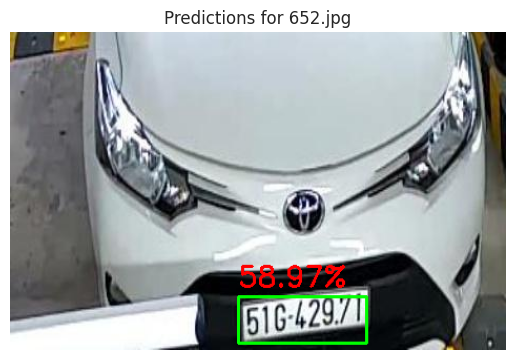


image 1/1 /kaggle/working/data/test/495.jpg: 416x640 1 license_plate, 210.8ms
Speed: 1.8ms preprocess, 210.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


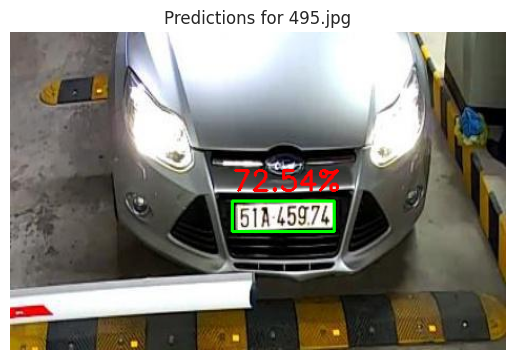


image 1/1 /kaggle/working/data/test/139.jpg: 416x640 1 license_plate, 211.2ms
Speed: 1.8ms preprocess, 211.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


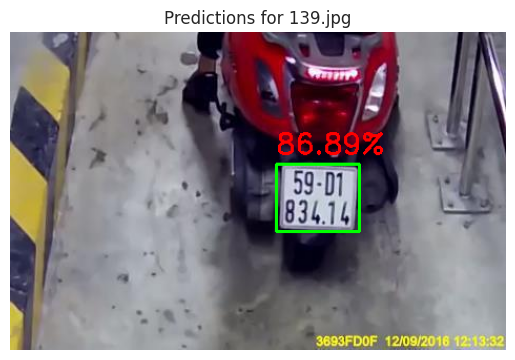


image 1/1 /kaggle/working/data/test/408.jpg: 416x640 1 license_plate, 234.4ms
Speed: 2.9ms preprocess, 234.4ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


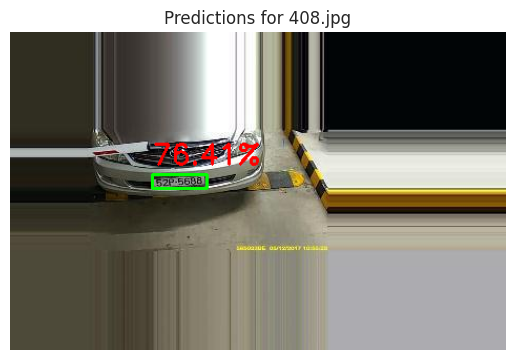


image 1/1 /kaggle/working/data/test/230.jpg: 416x640 1 license_plate, 211.1ms
Speed: 1.7ms preprocess, 211.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


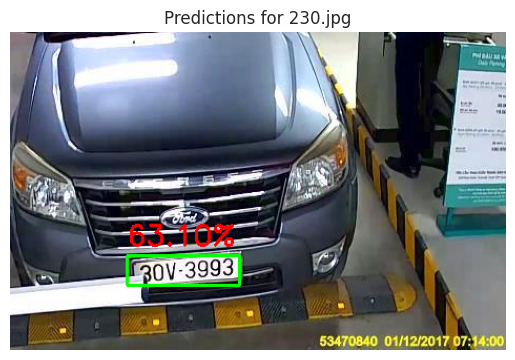


image 1/1 /kaggle/working/data/test/154.jpg: 416x640 1 license_plate, 209.2ms
Speed: 2.4ms preprocess, 209.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


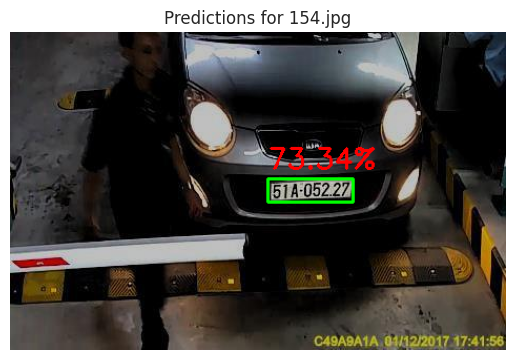


image 1/1 /kaggle/working/data/test/151.jpg: 416x640 2 license_plates, 230.7ms
Speed: 1.7ms preprocess, 230.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


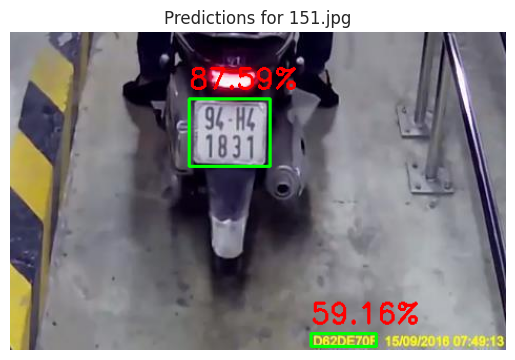


image 1/1 /kaggle/working/data/test/162.jpg: 416x640 1 license_plate, 213.6ms
Speed: 1.7ms preprocess, 213.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


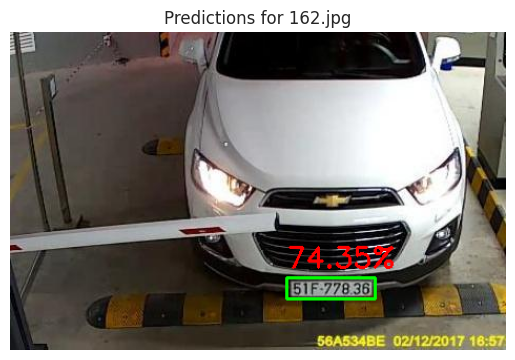


image 1/1 /kaggle/working/data/test/315.jpg: 416x640 1 license_plate, 224.0ms
Speed: 1.7ms preprocess, 224.0ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


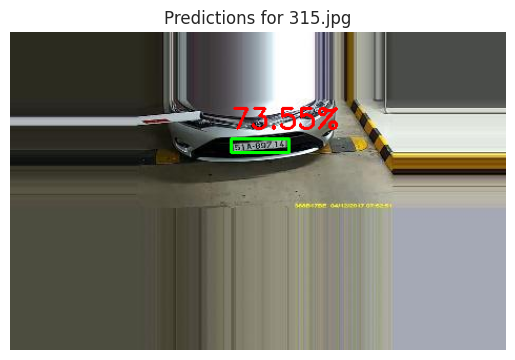


image 1/1 /kaggle/working/data/test/692.jpg: 416x640 1 license_plate, 207.7ms
Speed: 1.7ms preprocess, 207.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


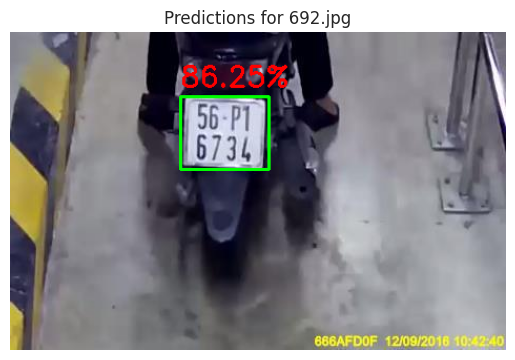


image 1/1 /kaggle/working/data/test/544.jpg: 416x640 1 license_plate, 223.5ms
Speed: 1.8ms preprocess, 223.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


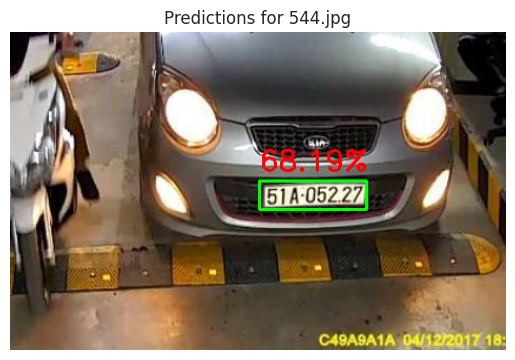


image 1/1 /kaggle/working/data/test/727.jpg: 416x640 3 license_plates, 217.0ms
Speed: 2.6ms preprocess, 217.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


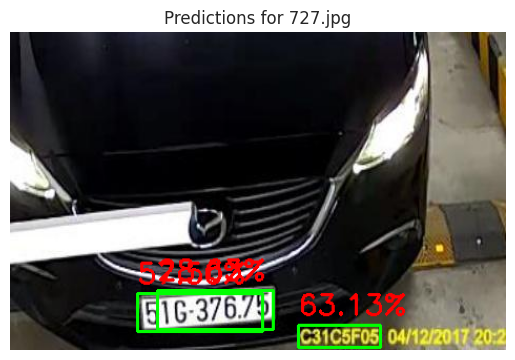


image 1/1 /kaggle/working/data/test/558.jpg: 416x640 1 license_plate, 207.7ms
Speed: 1.8ms preprocess, 207.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


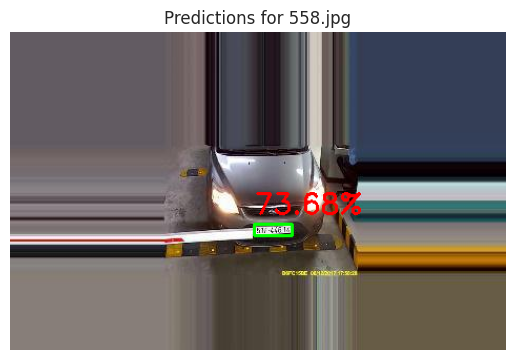


image 1/1 /kaggle/working/data/test/114.jpg: 416x640 2 license_plates, 208.9ms
Speed: 1.8ms preprocess, 208.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


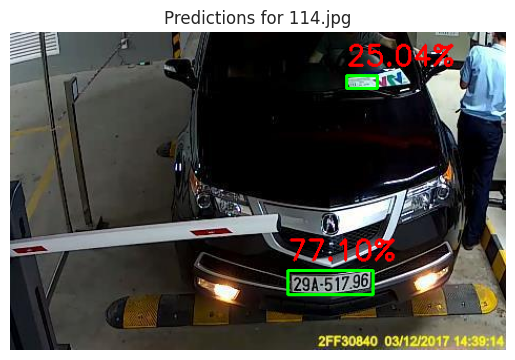


image 1/1 /kaggle/working/data/test/555.jpg: 416x640 1 license_plate, 218.4ms
Speed: 1.8ms preprocess, 218.4ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


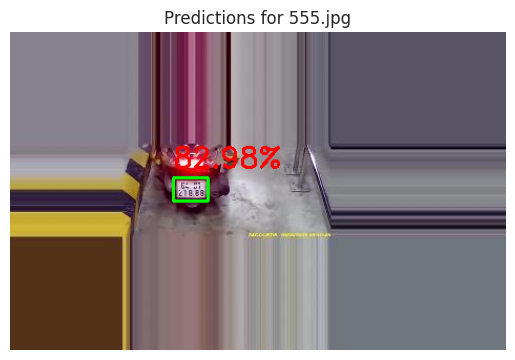


image 1/1 /kaggle/working/data/test/331.jpg: 416x640 1 license_plate, 206.4ms
Speed: 2.5ms preprocess, 206.4ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


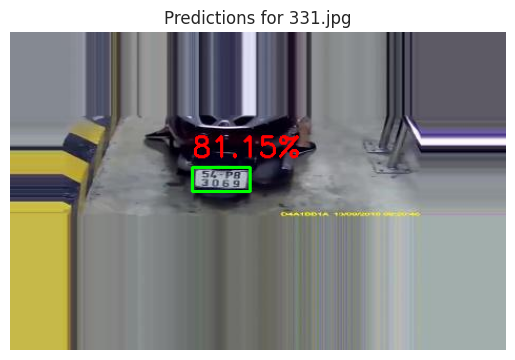


image 1/1 /kaggle/working/data/test/179.jpg: 416x640 1 license_plate, 195.7ms
Speed: 2.6ms preprocess, 195.7ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


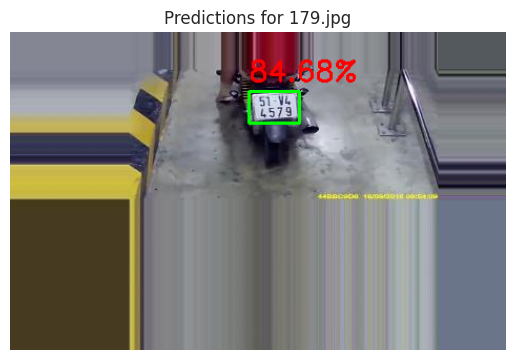


image 1/1 /kaggle/working/data/test/163.jpg: 416x640 1 license_plate, 210.0ms
Speed: 1.6ms preprocess, 210.0ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


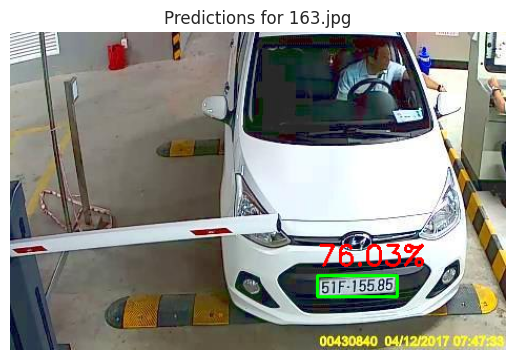


image 1/1 /kaggle/working/data/test/595.jpg: 416x640 2 license_plates, 199.6ms
Speed: 2.3ms preprocess, 199.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


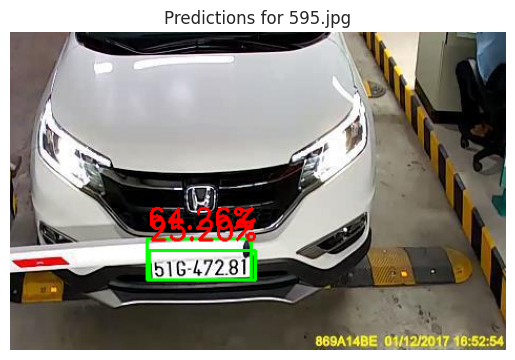


image 1/1 /kaggle/working/data/test/802.jpg: 416x640 1 license_plate, 217.0ms
Speed: 2.7ms preprocess, 217.0ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


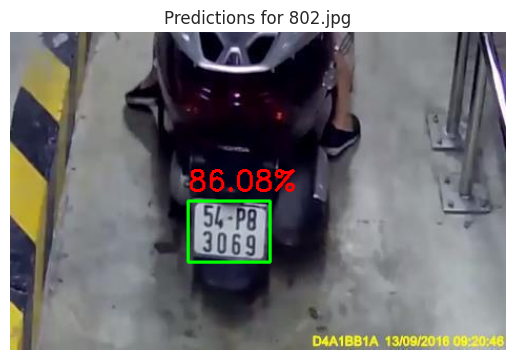

In [42]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

def predict_and_plot_directory(directory_path, num_images=20):
    # Listing all image files in the directory
    all_images = [f for f in os.listdir(directory_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if len(all_images) == 0:
        print("No images found in the directory.")
        return
    
    # Randomly selecting a subset of images
    selected_images = random.sample(all_images, min(num_images, len(all_images)))

    for image_file in selected_images:
        path_test_car = os.path.join(directory_path, image_file)

        # Performing prediction on the test image using the model
        results_yolo = model.predict(path_test_car, device='cpu')

        image = cv2.imread(path_test_car)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Extract the bounding boxes and labels from the results
        for result in results_yolo:
            for box in result.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                confidence = box.conf[0]

                # Drawing the bounding box on the image
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                # Draw the confidence score near the bounding box
                cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

        # Plotting the image with bounding boxes
        plt.imshow(image)
        plt.axis('off')  
        plt.title(f"Predictions for {image_file}")
        plt.show()  # Displaying the image

# Loading trained YOLO model
model = YOLO('/kaggle/working/best_license_plate_model.pt')
predict_and_plot_directory('/kaggle/working/data/test', num_images=20)     # predicting and visualsing 20 images

# Comparison of Implemented Models

In [93]:
# Creating an empty DataFrame to compare outputs
result_data = pd.DataFrame(columns=['Model', 'Loss', 'Accuracy', 'mAP'])

# result data
data = {
    'Model': ['EfficientNet', 'NasNet', 'Yolov9'],
    'Loss': [8.3631, 15.2259, results['val/box_loss'][9]],
    'Accuracy': [0.9263, 0.7913, 2*(results['metrics/precision(B)'][9])*(results['metrics/recall(B)'][9])/((results['metrics/precision(B)'][9])+(results['metrics/recall(B)'][9]))],
    'mAP': [0.2339, 0.1907, results['metrics/mAP50(B)'][9]]
}

# Appending data to the DataFrame
result_data = (pd.DataFrame(data))
result_data.head()

Model     Loss  Accuracy      mAP
0  EfficientNet   8.3631  0.926300  0.23390
1        NasNet  15.2259  0.791300  0.19070
2        Yolov9   1.0693  0.942777  0.95055

#### Accuracy Comparison

In [94]:
# Creating bar plot to Compare the Accuracy of Models
fig = go.Figure()

fig.add_trace(go.Bar(
    x=result_data['Model'],
    y=result_data['Accuracy'],
    marker_color=['blue', 'orange', 'green'],
    width=[0.3, 0.3, 0.3],  
    text=[f'{acc*100:.2f}%' for acc in result_data['Accuracy']],  
    textposition='inside',  
    textfont=dict(color='white')  
))

# Updating layout with background color and other customizations
fig.update_layout(
    title='Model Accuracy Comparison',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    yaxis=dict(range=[0, 1]),  
    template='plotly_white',  
    plot_bgcolor='lightgrey',  
    paper_bgcolor='white',     
    font=dict(size=12)         
)

# Showing plot
fig.show()

#### Mean Avearge Precision Comparison

In [95]:
# Comparing Models on mAP (mean Average Precision) using ploar scatter plot
result_data['angle'] = result_data['Model'].apply(lambda x: result_data['Model'].tolist().index(x) * 360 / len(result_data))
result_data['radius'] = result_data['mAP']

# Creating polar scatter plot
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=result_data['radius'].tolist() + [result_data['radius'].tolist()[0]],  
    theta=result_data['angle'].tolist() + [result_data['angle'].tolist()[0]],  
    mode='markers+text',
    marker=dict(size=12, color='red'),
    text=result_data['Model'].tolist() + [result_data['Model'].tolist()[0]],  
    textposition='top center',
    fill='toself',  # Fill color inside the plot area
    fillcolor='rgba(120, 250, 0, 0.5)'  
))

# Updating layout with polar settings and background color
fig.update_layout(
    title='Model mAP Comparison (Polar Plot)',
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]  
        ),
        angularaxis=dict(
            visible=True
        )
    ),
    paper_bgcolor='white',  
    plot_bgcolor='white'  
)

# Showing plot
fig.show()

#### Loss Comparison

In [96]:
# Creating a treemap to compare models based on the Loss
fig = go.Figure(go.Treemap(
    labels=result_data['Model'],
    parents=['']*len(result_data['Model']),
    values=result_data['Loss'],
    textinfo='label+value',
    marker=dict(
        colors=result_data['Loss'],
        colorscale='Viridis',  
        colorbar=dict(title='Loss')
    )
))

# Updating layout
fig.update_layout(
    title='Model Loss Comparison (Treemap)',
    paper_bgcolor='white', 
    plot_bgcolor='lightgrey'  
)

# Showing plot
fig.show()

# Implementing Optical Character Recognition

Since the mAP value and accuracy of Yolo V9 model is highest whilst having lowest loss among the other models therefore using YOLO V9 mdoel for OCR.

In [ ]:
!pip3 install pytesseract               # installing pytesseract for OCR

In [ ]:
import pytesseract                          # importing pytesseract
from pytesseract import Output         

In [13]:
def predict_and_plot(path_test_car):
    # Performing prediction on the test image using the model
    results_yolo = model.predict(path_test_car, device='cpu')

    # Loading the image using OpenCV
    image = cv2.imread(path_test_car)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extracting the bounding boxes and labels from the results
    for result in results_yolo:
        for box in result.boxes:
            # Getting the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Getting the confidence score of the prediction
            confidence = box.conf[0]

            # Drawing the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

            roi = image[y1:y2, x1:x2]

            # Performing OCR on the image
            text = pytesseract.image_to_string(roi, config='--psm 6')
            print(f"Detected text: {text}")

    # Plotting the images
    plt.imshow(image)
    plt.axis('off')  
    plt.show()  # Displaying the image


image 1/1 /kaggle/working/data/test/1.jpg: 128x224 1 license_plate, 50.3ms
Speed: 0.9ms preprocess, 50.3ms inference, 0.7ms postprocess per image at shape (1, 3, 128, 224)
Detected text: MH 20EE 7598 |



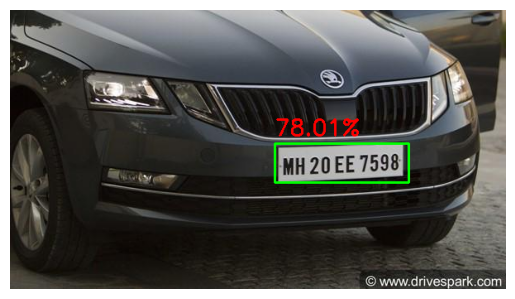

In [26]:
predict_and_plot('/kaggle/working/data/test/1.jpg')


image 1/1 /kaggle/working/data/test/2.jpg: 96x224 1 license_plate, 49.4ms
Speed: 3.9ms preprocess, 49.4ms inference, 0.8ms postprocess per image at shape (1, 3, 96, 224)
Detected text: =MH12B67237.



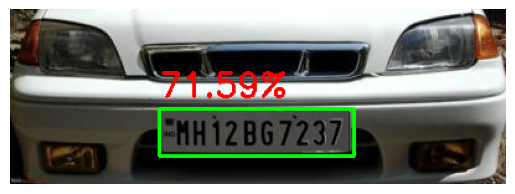

In [27]:
predict_and_plot('/kaggle/working/data/test/2.jpg')


image 1/1 /kaggle/working/data/test/30.jpg: 160x224 1 license_plate, 57.0ms
Speed: 0.9ms preprocess, 57.0ms inference, 0.7ms postprocess per image at shape (1, 3, 160, 224)
Detected text: VUS3 CTY!



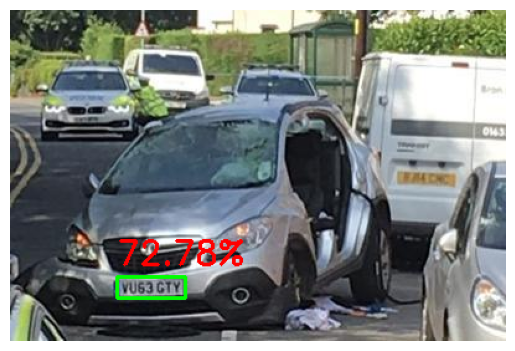

In [28]:
predict_and_plot('/kaggle/working/data/test/30.jpg')


image 1/1 /kaggle/working/data/test/147.jpg: 160x224 1 license_plate, 60.4ms
Speed: 0.7ms preprocess, 60.4ms inference, 1.0ms postprocess per image at shape (1, 3, 160, 224)
Detected text: (5 1F-079.73)



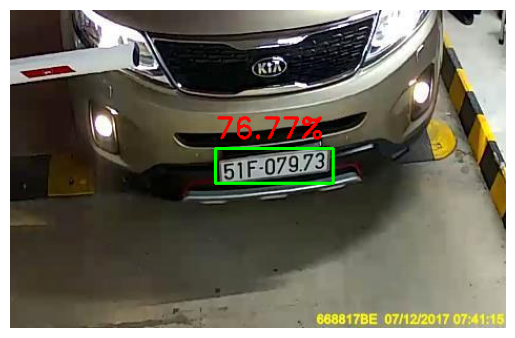

In [40]:
predict_and_plot('/kaggle/working/data/test/147.jpg')